# cs8321 Lab 3 - CNN Visualization

#### Chip Henderson - 48996654

In this lab you will find and analyze a circuit in a common neural network.  A reference figure is also shown to help clarify the process of finding and analyzing deep circuits.

The terminology used in this labs is as follows: (1) a filter refers to the entire tensor that convolves with an input across all channels (i.e., a multi-channel filter like a 3x3x64 tensor), (2) a single channel filter refers to one channel of the aforementioned filter (e.g., a 3x3x1 convolution kernel), (3) and activation refers to the input or output of the filter depending on context (i.e., input activations for a filter are the inputs from a previous layer, output activations are all the filter outputs from a convolutional layer), (4) an input can refer to all input channels or a single input channel depending on the context (entire filter or single channel filter, respectively). A diagram is provided for clarity and this was covered in detail in the class lecture.

[3 Points] In groups, you should select a convolutional neural network model that has been pre-trained on a large dataset (preferably, ImageNet). These already trained models are readily available online through many mechanisms, including the keras.application package (Inception, Xception, VGG etc.) https://keras.io/api/applications/Links to an external site.  
It is recommended to select a model with somewhat simple structure, like VGG. This can help to simplify how to extract specific filters and inputs to filters later on.  
 Explain the model you chose and why.  Classify a few images with pre-trained network to verify that it is working properly.

Let's pull in VGG16 and try to classify some images. I don't have any image datasets locally to I need some representative samples to run through the model. It helps to understand what VGG was trained on in order to do this.

VGG-16 was trained on imagenet-1k, also known as ILSVRC 2012. This dataset contains images of varying class and is frequently used to pretrain deep learning models for computer vision. Here are some of the specifications:
 -  One thousand classes in total
 -  A datasplit of 1,281,167 training images, 50,000 validation images, and 100,000 test images was used
 -  The images in the dataset are classified using the WordNet hierarchy
 -  Each meaningful concept in WordNet, possibly described by multiple words or word phrases, is called a “synonym set” or “synset”. ImageNet aims to provide on average 1000 images to illustrate each synset. 
 -  The images of each concept are quality-controlled and human-annotated.

VGG19 is another good option for this lab. However, I'm being cognizant of my platform constraints and going with focusing on minimum viable models from a memory footprint perspective.

Source: https://paperswithcode.com/dataset/imagenet-1k-1#:~:text=The%20ImageNet1K%20dataset%2C%20also%20known,It%20spans%201000%20object%20classes.

In [4]:
# Source: https://keras.io/api/applications/
# Import the model, weights, and set up for classifiying test images

import keras
from keras.applications.vgg19 import VGG19
import numpy as np

model = VGG19(weights='imagenet', include_top=True)


574710816/574710816 [==============================] - 13s 0us/step


With the model imported, we'll pull a couple imageNet images to test performance. The input image size was typically 224x224, so I'll be using images of that same configuration here. I didn't want to download a full imagenet dataset, so I found a source providing one image from each of the 1,000 classes, and took 10 random samples from that.

Source: https://github.com/EliSchwartz/imagenet-sample-images/blob/master/README.md

In [2]:
# Source: Modified from https://keras.io/api/applications/
# and ChatGPT

import os
from tensorflow.keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

# These function were provided by ChatGPT and verified against
# The Keras applications API https://keras.io/api/applications/
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


def predict_image_class(img_path):
    img = preprocess_image(img_path)
    preds = model.predict(img)
    # Decode predictions, give the top 3
    decoded_preds = decode_predictions(preds, top=3)[0]
    return decoded_preds

images_dir = '../Data_Sources/imageNet_samples/'

# Get list of image filenames in the directory
image_files = os.listdir(images_dir)

# Iterate over each image and make predictions
for image_file in image_files:
    # print(image_file)
    img_path = os.path.join(images_dir, image_file)
    predictions = predict_image_class(img_path)
    print("Predictions for", image_file)
    for prediction in predictions:
        print(prediction)
    print('\n')

1/1 [==============================] - 0s 295ms/step
Predictions for n01440764_tench.JPEG
('n01440764', 'tench', 0.92435473)
('n01443537', 'goldfish', 0.040547248)
('n13054560', 'bolete', 0.011226594)


1/1 [==============================] - 0s 165ms/step
Predictions for n01498041_stingray.JPEG
('n01496331', 'electric_ray', 0.94126)
('n01498041', 'stingray', 0.053826265)
('n01910747', 'jellyfish', 0.0019548691)


1/1 [==============================] - 0s 160ms/step
Predictions for n01632458_spotted_salamander.JPEG
('n01632458', 'spotted_salamander', 0.9698313)
('n01629819', 'European_fire_salamander', 0.016018767)
('n01630670', 'common_newt', 0.013842585)


1/1 [==============================] - 0s 173ms/step
Predictions for n02130308_cheetah.JPEG
('n02130308', 'cheetah', 0.9185887)
('n02127052', 'lynx', 0.074765205)
('n02128757', 'snow_leopard', 0.0029449621)


1/1 [==============================] - 0s 168ms/step
Predictions for n02174001_rhinoceros_beetle.JPEG
('n02174001', 'rhinocer

Generally everything turns out as expected from these samples. Predicting Electric Ray instead of Stingray is probably forgivable. 

Next, I'm going to be looking at which layer to study for this lab. To start, it helps to visualize the VGG architecture.

[4 Points] Select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit. This should be a multi-channel filter in a "mid-level" portion of the network (that is, there are convolutional layers before and after this chosen layer). You might find using OpenAI microscope a helpful tool for selecting a filter to analyze without writing too much code: https://microscope.openai.com/models/Links to an external site. 
Using image gradient techniques, find an input image that maximally excites this chosen multi-channel filter. General techniques are available from class: https://github.com/8000net/LectureNotesMaster/blob/master/04%20LectureVisualizingConvnets.ipynbLinks to an external site.
Also send images of varying class (i.e., from ImageNet) through the network and track which classes of images most excite your chosen filter. 
Give a hypothesis for what this multi-channel filter might be extracting. That is, what do you think its function is in the network? Give reasoning for your hypothesis. 
If using code from another source or a LLM, you should heavily document the code so that I can grade your understanding of the code used. 

Fort he sake of simplicity, I'll use what was recommended in class by selecting Block 5 Conv1

![VGG-19 Architecture.png](<attachment:VGG-19 Architecture.png>)
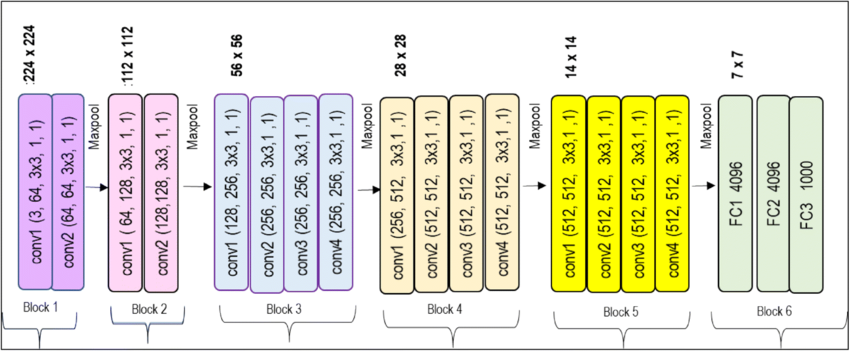

**Start with the code that is in the notebook 04 LectureVisualizingConvnets at the heading "Visualizing Convolutional Filters Excitations in VGG16"**

[4 Points] Analyze each channel of the multi-channel filter to better understand how this might form a circuit (i.e., the weights of the filter). That is, visualize the convolutional filter (one channel at a time) between the input activations and the current activation to understand which inputs make up a circuit. You should avoid filter channels that are mostly "zero" coefficients. These are not influential for the circuit. One method of doing this is given below:
Extract the filter coefficients for each input activation to that multi-channel filter. Note: If the multi-channel filter is 5x5 with an input channel size of 64, then this extraction will result in 64 different single channel filters, each of size 5x5. 
Keep the top ten sets of inputs with the "strongest" weights. For now, you can use the L2 norm of each input filter as a measure of strength. Visualize these top ten filters. 
For these ten strongest input filters, categorize each as "mostly inhibitory" or "mostly excitatory." That is, does each filter consist of mostly negative or mostly positive coefficients?  

[4 Points] For each of the ten chosen single channels of the filter, use image gradient techniques to visualize what each of these filters is most excited by (that is, what image maximally excites each of these filters?). This is a similar analysis to the first step in this rubric, but now isolating the activations the layer preceding your chosen filter. This should only be completed for the ten most influential filters.  
Use these visualizations, along with the circuit weights you just discovered to try and explain how this particular circuit works. An example of this visualization style can be seen here: https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/mixed3b_379.htmlLinks to an external site. 
Try to define the properties of this circuit using vocabulary from https://distill.pub/2020/circuits/zoom-in/Links to an external site. (such as determining if this is polysemantic, pose-invariant, etc.)  
Relate your visualizations back to your original hypothesis about what this filter is extracting. Does it support or refute your hypothesis? Why? 